In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve)

# Modelos
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Balanceamento
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

print("TREINAMENTO DE MODELOS - PREDIÇÃO DE DEPRESSÃO EM ESTUDANTES")
print("="*70)

TREINAMENTO DE MODELOS - PREDIÇÃO DE DEPRESSÃO EM ESTUDANTES


In [17]:
# 1. CARREGAMENTO E PREPARAÇÃO DOS DADOS

print("\n[ETAPA 1] CARREGAMENTO DOS DADOS\n")

df = pd.read_csv('../data/student_depression_dataset.csv')
print(f"✓ Dataset carregado: {len(df)} registros, {len(df.columns)} colunas")

# Cópia para preservar original
df_original = df.copy()


[ETAPA 1] CARREGAMENTO DOS DADOS

✓ Dataset carregado: 27901 registros, 18 colunas


In [ ]:
# 2. PRÉ-PROCESSAMENTO

print("\n" + "="*70)
print("[ETAPA 2] PRÉ-PROCESSAMENTO DOS DADOS")
print("="*70)

print("\n→ Tratamento de valores ausentes...")

df = df.dropna()
print(f"  ✓ Dataset após remoção de NaN: {len(df)} registros")

# Identifica coluna target
depression_col = [col for col in df.columns if 'depress' in col.lower() or 'target' in col.lower()]
if depression_col:
    target_col = depression_col[0]
else:   
    target_col = df.columns[-1]

print(f"\n→ Coluna target identificada: '{target_col}'")

# Codificação de variáveis categóricas
print("\n→ Codificando variáveis categóricas...")
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

if target_col in categorical_cols:
    categorical_cols.remove(target_col)

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    print(f"  ✓ {col} codificado")

if df[target_col].dtype == 'object':
    le_target = LabelEncoder()
    df[target_col] = le_target.fit_transform(df[target_col])
    label_encoders['target'] = le_target
    print(f"  ✓ Target '{target_col}' codificado")


[ETAPA 2] PRÉ-PROCESSAMENTO DOS DADOS

→ Tratamento de valores ausentes...
  ✓ Dataset após remoção de NaN: 27901 registros

→ Coluna target identificada: 'Depression'

→ Codificando variáveis categóricas...
  ✓ Gender codificado
  ✓ City codificado
  ✓ Profession codificado
  ✓ Sleep Duration codificado
  ✓ Dietary Habits codificado
  ✓ Degree codificado
  ✓ Have you ever had suicidal thoughts ? codificado
  ✓ Financial Stress codificado
  ✓ Family History of Mental Illness codificado


In [ ]:
# 3. SEPARAÇÃO DE FEATURES E TARGET

print("\n" + "="*70)
print("[ETAPA 3] SEPARAÇÃO DOS DADOS")
print("="*70)

X = df.drop(target_col, axis=1)
y = df[target_col]

print(f"\n→ Features (X): {X.shape}")
print(f"→ Target (y): {y.shape}")

print(f"\n→ Distribuição da variável target:")
print(y.value_counts())
print(f"\n→ Proporção:")
for value, count in y.value_counts(normalize=True).items():
    print(f"  Classe {value}: {count*100:.2f}%")


[ETAPA 3] SEPARAÇÃO DOS DADOS

→ Features (X): (27901, 17)
→ Target (y): (27901,)

→ Distribuição da variável target:
Depression
1    16336
0    11565
Name: count, dtype: int64

→ Proporção:
  Classe 1: 58.55%
  Classe 0: 41.45%


In [20]:
# 4. DIVISÃO TREINO/TESTE

print("\n" + "="*70)
print("[ETAPA 4] DIVISÃO TREINO/TESTE")
print("="*70)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n→ Treino: {len(X_train)} amostras ({len(X_train)/len(X)*100:.1f}%)")
print(f"→ Teste: {len(X_test)} amostras ({len(X_test)/len(X)*100:.1f}%)")


[ETAPA 4] DIVISÃO TREINO/TESTE

→ Treino: 22320 amostras (80.0%)
→ Teste: 5581 amostras (20.0%)


In [21]:
# 5. NORMALIZAÇÃO DOS DADOS

print("\n" + "="*70)
print("[ETAPA 5] NORMALIZAÇÃO (STANDARDIZATION)")
print("="*70)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Dados normalizados (média=0, desvio padrão=1)")


[ETAPA 5] NORMALIZAÇÃO (STANDARDIZATION)

✓ Dados normalizados (média=0, desvio padrão=1)


In [ ]:
# 6. BALANCEAMENTO COM SMOTE (SE NECESSÁRIO)

print("\n" + "="*70)
print("[ETAPA 6] BALANCEAMENTO DE CLASSES")
print("="*70)

# Verifica se há desbalanceamento significativo
class_counts = y_train.value_counts()
ratio = class_counts.max() / class_counts.min()

print(f"\n→ Razão de desbalanceamento: {ratio:.2f}")

if ratio > 2:
    print("Dataset desbalanceado! Aplicando SMOTE...")
    
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)
    
    print(f"\n→ Antes do SMOTE: {len(X_train_scaled)} amostras")
    print(f"→ Depois do SMOTE: {len(X_train_balanced)} amostras")
    print(f"\n→ Nova distribuição:")
    print(pd.Series(y_train_balanced).value_counts())
    
    X_train_final = X_train_balanced
    y_train_final = y_train_balanced
else:
    print("✓ Dataset equilibrado, SMOTE não necessário")
    X_train_final = X_train_scaled
    y_train_final = y_train


[ETAPA 6] BALANCEAMENTO DE CLASSES

→ Razão de desbalanceamento: 1.41
✓ Dataset equilibrado, SMOTE não necessário


In [ ]:
# 7. TREINAMENTO DE MÚLTIPLOS MODELOS

print("\n" + "="*70)
print("[ETAPA 7] TREINAMENTO E COMPARAÇÃO DE MODELOS")
print("="*70)

# Dicionário de modelos
modelos = {
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(random_state=42, probability=True),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

resultados = []

print("\n→ Treinando e avaliando modelos...\n")

for nome, modelo in modelos.items():
    print(f"[{nome}]")
    
    # Treina
    modelo.fit(X_train_final, y_train_final)
    
    # Predições
    y_pred = modelo.predict(X_test_scaled)
    y_pred_proba = modelo.predict_proba(X_test_scaled)[:, 1] if hasattr(modelo, 'predict_proba') else None
    
    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Cross-validation
    cv_scores = cross_val_score(modelo, X_train_final, y_train_final, cv=5)
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    print(f"  Acurácia: {accuracy:.4f}")
    print(f"  Precisão: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  CV Score: {cv_mean:.4f} (+/- {cv_std:.4f})")
    
    # AUC-ROC
    if len(np.unique(y)) == 2 and y_pred_proba is not None:
        auc = roc_auc_score(y_test, y_pred_proba)
        print(f"  AUC-ROC: {auc:.4f}")
    else:
        auc = None
    
    print()
    
    resultados.append({
        'Modelo': nome,
        'Acurácia': accuracy,
        'Precisão': precision,
        'Recall': recall,
        'F1-Score': f1,
        'CV Score': cv_mean,
        'CV Std': cv_std,
        'AUC-ROC': auc
    })



[ETAPA 7] TREINAMENTO E COMPARAÇÃO DE MODELOS

→ Treinando e avaliando modelos...

[Random Forest]
  Acurácia: 0.8396
  Precisão: 0.8391
  Recall: 0.8396
  F1-Score: 0.8392
  CV Score: 0.8422 (+/- 0.0056)
  AUC-ROC: 0.9134

[Gradient Boosting]
  Acurácia: 0.8464
  Precisão: 0.8459
  Recall: 0.8464
  F1-Score: 0.8459
  CV Score: 0.8475 (+/- 0.0068)
  AUC-ROC: 0.9189

[Logistic Regression]
  Acurácia: 0.8427
  Precisão: 0.8421
  Recall: 0.8427
  F1-Score: 0.8422
  CV Score: 0.8468 (+/- 0.0068)
  AUC-ROC: 0.9174

[Decision Tree]
  Acurácia: 0.8092
  Precisão: 0.8084
  Recall: 0.8092
  F1-Score: 0.8086
  CV Score: 0.8125 (+/- 0.0055)
  AUC-ROC: 0.8525

[Naive Bayes]
  Acurácia: 0.5852
  Precisão: 0.3428
  Recall: 0.5852
  F1-Score: 0.4323
  CV Score: 0.5855 (+/- 0.0002)
  AUC-ROC: 0.9144

[SVM]
  Acurácia: 0.8420
  Precisão: 0.8415
  Recall: 0.8420
  F1-Score: 0.8411
  CV Score: 0.8444 (+/- 0.0063)
  AUC-ROC: 0.9100

[KNN]
  Acurácia: 0.8138
  Precisão: 0.8130
  Recall: 0.8138
  F1-Score:


[ETAPA 8] COMPARAÇÃO VISUAL DOS MODELOS

📊 TABELA DE RESULTADOS:

             Modelo  Acurácia  Precisão   Recall  F1-Score  CV Score   CV Std  AUC-ROC
      Random Forest  0.839634  0.839092 0.839634  0.839163  0.842204 0.005586 0.913439
  Gradient Boosting  0.846443  0.845923 0.846443  0.845886  0.847491 0.006810 0.918858
Logistic Regression  0.842681  0.842147 0.842681  0.842188  0.846819 0.006754 0.917406
      Decision Tree  0.809174  0.808416 0.809174  0.808584  0.812500 0.005547 0.852549
        Naive Bayes  0.585200  0.342791 0.585200  0.432335  0.585529 0.000168 0.914438
                SVM  0.841964  0.841460 0.841964  0.841115  0.844355 0.006300 0.910005
                KNN  0.813833  0.812984 0.813833  0.812809  0.814382 0.007243 0.870123


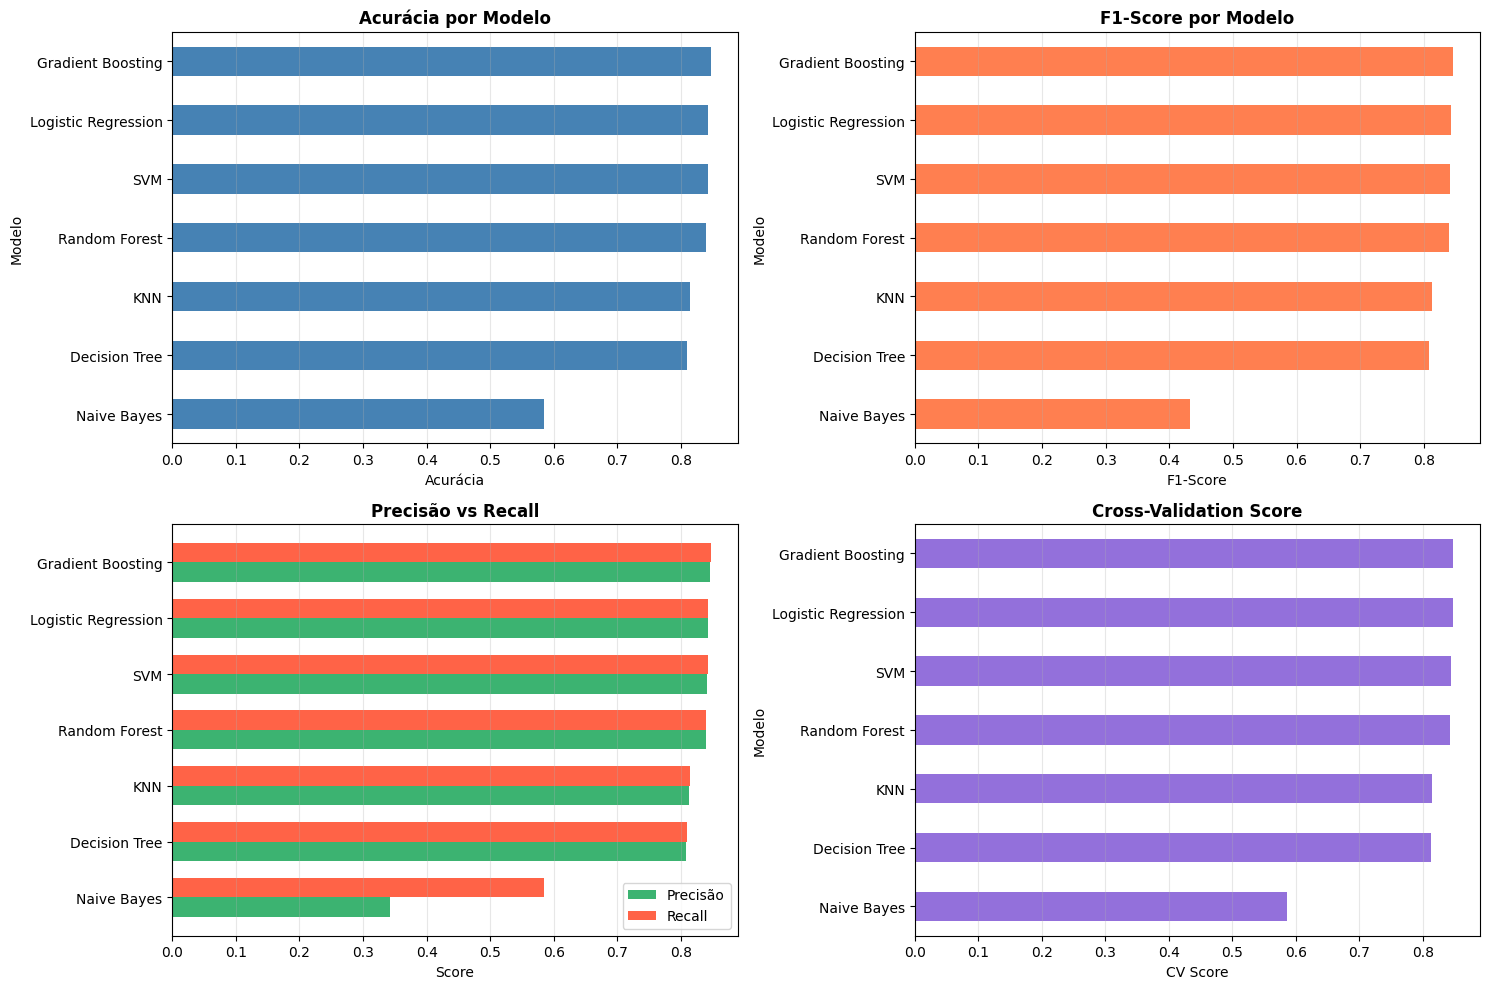

In [ ]:
# 8. COMPARAÇÃO VISUAL DOS MODELOS

print("[ETAPA 8] COMPARAÇÃO VISUAL DOS MODELOS")
print("="*70)

df_resultados = pd.DataFrame(resultados)
print("\nTABELA DE RESULTADOS:\n")
print(df_resultados.to_string(index=False))

# Gráfico comparativo
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Acurácia
df_resultados.sort_values('Acurácia', ascending=True).plot(
    x='Modelo', y='Acurácia', kind='barh', ax=axes[0, 0], 
    color='steelblue', legend=False
)
axes[0, 0].set_title('Acurácia por Modelo', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Acurácia')
axes[0, 0].grid(axis='x', alpha=0.3)

# F1-Score
df_resultados.sort_values('F1-Score', ascending=True).plot(
    x='Modelo', y='F1-Score', kind='barh', ax=axes[0, 1], 
    color='coral', legend=False
)
axes[0, 1].set_title('F1-Score por Modelo', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('F1-Score')
axes[0, 1].grid(axis='x', alpha=0.3)

# Precisão e Recall
df_resultados_sorted = df_resultados.sort_values('Acurácia')
x = np.arange(len(df_resultados_sorted))
width = 0.35
axes[1, 0].barh(x - width/2, df_resultados_sorted['Precisão'], width, label='Precisão', color='mediumseagreen')
axes[1, 0].barh(x + width/2, df_resultados_sorted['Recall'], width, label='Recall', color='tomato')
axes[1, 0].set_yticks(x)
axes[1, 0].set_yticklabels(df_resultados_sorted['Modelo'])
axes[1, 0].set_xlabel('Score')
axes[1, 0].set_title('Precisão vs Recall', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(axis='x', alpha=0.3)

# Cross-Validation Score
df_resultados.sort_values('CV Score', ascending=True).plot(
    x='Modelo', y='CV Score', kind='barh', ax=axes[1, 1], 
    color='mediumpurple', legend=False
)
axes[1, 1].set_title('Cross-Validation Score', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('CV Score')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../visualizations/comparacao_modelos.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# 9. SELEÇÃO DO MELHOR MODELO
print("[ETAPA 9] SELEÇÃO DO MELHOR MODELO")
print("="*70)

# Seleciona melhor modelo baseado em F1-Score
melhor_idx = df_resultados['F1-Score'].idxmax()
melhor_modelo_nome = df_resultados.loc[melhor_idx, 'Modelo']
melhor_modelo = modelos[melhor_modelo_nome]

print(f"\nMELHOR MODELO: {melhor_modelo_nome}")
print(f"F1-Score: {df_resultados.loc[melhor_idx, 'F1-Score']:.4f}")
print(f"Acurácia: {df_resultados.loc[melhor_idx, 'Acurácia']:.4f}")

# Retreina o melhor modelo (já está treinado, mas por clareza)
melhor_modelo.fit(X_train_final, y_train_final)
y_pred_final = melhor_modelo.predict(X_test_scaled)


[ETAPA 9] SELEÇÃO DO MELHOR MODELO

MELHOR MODELO: Gradient Boosting
F1-Score: 0.8459
Acurácia: 0.8464



[ETAPA 10] ANÁLISE DETALHADA DO MELHOR MODELO

RELATÓRIO DE CLASSIFICAÇÃO:

              precision    recall  f1-score   support

           0       0.83      0.79      0.81      2313
           1       0.86      0.88      0.87      3268

    accuracy                           0.85      5581
   macro avg       0.84      0.84      0.84      5581
weighted avg       0.85      0.85      0.85      5581

\MATRIZ DE CONFUSÃO:

[[1833  480]
 [ 377 2891]]


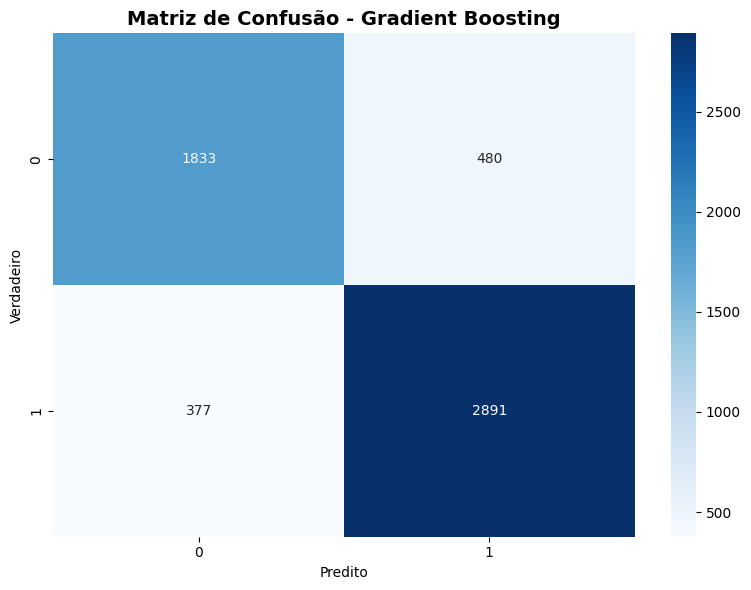

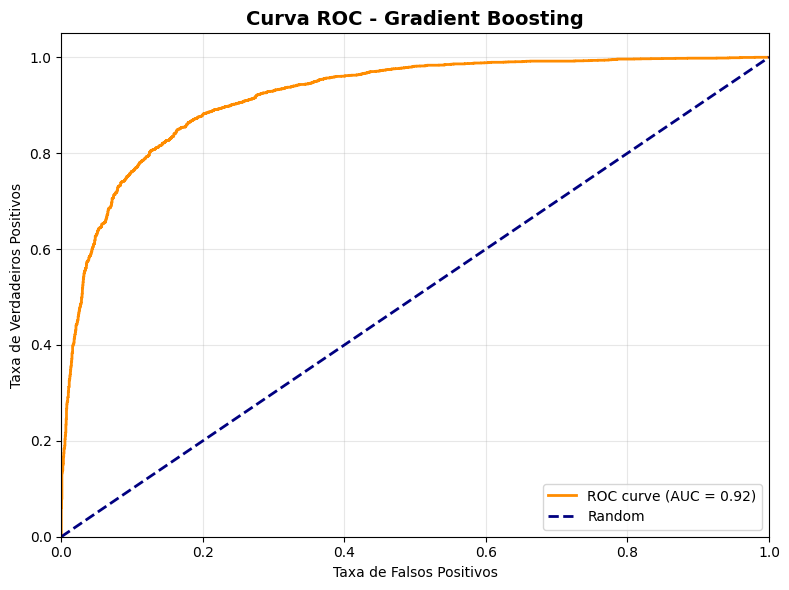


[ETAPA 11] IMPORTÂNCIA DAS FEATURES

TOP 10 FEATURES MAIS IMPORTANTES:

                              Feature  Importância
Have you ever had suicidal thoughts ?     0.516937
                    Academic Pressure     0.238543
                     Financial Stress     0.116384
                                  Age     0.047518
                     Work/Study Hours     0.026871
                       Dietary Habits     0.026173
                   Study Satisfaction     0.014175
                       Sleep Duration     0.004606
                                 CGPA     0.002577
     Family History of Mental Illness     0.002046


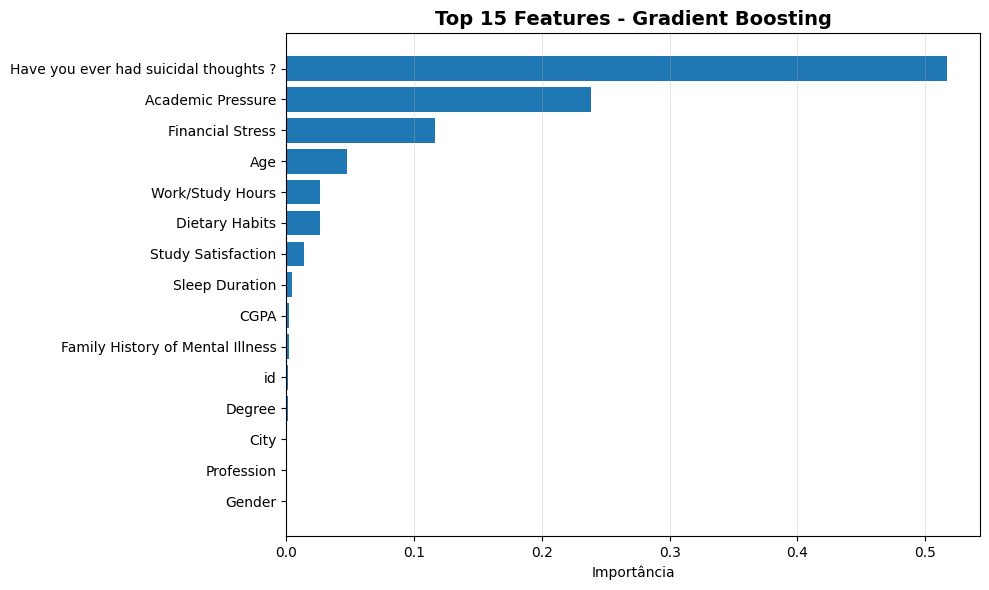

In [ ]:
# 10. ANÁLISE DETALHADA DO MELHOR MODELO

print("[ETAPA 10] ANÁLISE DETALHADA DO MELHOR MODELO")
print("="*70)

print("\nRELATÓRIO DE CLASSIFICAÇÃO:\n")
print(classification_report(y_test, y_pred_final))

# Matriz de Confusão
print("\MATRIZ DE CONFUSÃO:\n")
cm = confusion_matrix(y_test, y_pred_final)
print(cm)

# Visualização da Matriz de Confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title(f'Matriz de Confusão - {melhor_modelo_nome}', fontsize=14, fontweight='bold')
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.tight_layout()
plt.savefig('../visualizations/matriz_confusao.png', dpi=300, bbox_inches='tight')
plt.show()

# Curva ROC
if len(np.unique(y)) == 2:
    y_pred_proba_final = melhor_modelo.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_final)
    roc_auc = roc_auc_score(y_test, y_pred_proba_final)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title(f'Curva ROC - {melhor_modelo_nome}', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('../visualizations/curva_roc.png', dpi=300, bbox_inches='tight')
    plt.show()

# Feature Importance
if hasattr(melhor_modelo, 'feature_importances_'):
    print("\n" + "="*70)
    print("[ETAPA 11] IMPORTÂNCIA DAS FEATURES")
    print("="*70)
    
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importância': melhor_modelo.feature_importances_
    }).sort_values('Importância', ascending=False)
    
    print("\nTOP 10 FEATURES MAIS IMPORTANTES:\n")
    print(feature_importance.head(10).to_string(index=False))
    
    # Visualização
    plt.figure(figsize=(10, 6))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['Importância'])
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Importância')
    plt.title(f'Top 15 Features - {melhor_modelo_nome}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('../visualizations/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
# 12. SALVAMENTO DO MODELO E ARTEFATOS

print("\n" + "="*70)
print("[ETAPA 12] SALVAMENTO DO MODELO")
print("="*70)

with open('../models/modelo_depressao.pkl', 'wb') as f:
    pickle.dump(melhor_modelo, f)
print(f"\n✓ Modelo salvo: ../models/modelo_depressao.pkl")

with open('../models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print(f"✓ Scaler salvo: ../models/scaler.pkl")

with open('../models/label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)
print(f"✓ Label Encoders salvos: ../models/label_encoders.pkl")

with open('../models/feature_names.pkl', 'wb') as f:
    pickle.dump(X.columns.tolist(), f)
print(f"✓ Feature names salvos: ../models/feature_names.pkl")

# Salva informações do modelo
model_info = {
    'modelo_nome': melhor_modelo_nome,
    'acuracia': df_resultados.loc[melhor_idx, 'Acurácia'],
    'f1_score': df_resultados.loc[melhor_idx, 'F1-Score'],
    'precisao': df_resultados.loc[melhor_idx, 'Precisão'],
    'recall': df_resultados.loc[melhor_idx, 'Recall'],
    'target_col': target_col,
    'n_features': len(X.columns),
    'n_samples_train': len(X_train),
    'n_samples_test': len(X_test)
}

with open('../models/model_info.pkl', 'wb') as f:
    pickle.dump(model_info, f)
print(f"✓ Informações do modelo salvas: ../models/model_info.pkl")


[ETAPA 12] SALVAMENTO DO MODELO

✓ Modelo salvo: ../models/modelo_depressao.pkl
✓ Scaler salvo: ../models/scaler.pkl
✓ Label Encoders salvos: ../models/label_encoders.pkl
✓ Feature names salvos: ../models/feature_names.pkl
✓ Informações do modelo salvas: ../models/model_info.pkl


In [28]:
# 13. RESUMO FINAL

print("\n" + "="*70)
print("RESUMO FINAL DO TREINAMENTO")
print("="*70)

print(f"""
TREINAMENTO CONCLUÍDO COM SUCESSO!

ESTATÍSTICAS:
Total de modelos testados: {len(modelos)}
Melhor modelo: {melhor_modelo_nome}
Acurácia final: {df_resultados.loc[melhor_idx, 'Acurácia']:.4f}
F1-Score final: {df_resultados.loc[melhor_idx, 'F1-Score']:.4f}""")

print("="*70)


RESUMO FINAL DO TREINAMENTO

TREINAMENTO CONCLUÍDO COM SUCESSO!

ESTATÍSTICAS:
Total de modelos testados: 7
Melhor modelo: Gradient Boosting
Acurácia final: 0.8464
F1-Score final: 0.8459
